In [1]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
from scipy.optimize import fmin
from tqdm import tqdm
from sklearn import datasets

%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

### Linear regression

A linear regression model makes a prediction from a weighted sum of input features (and a bias term)

$$ \hat y = \theta_0 + \theta_1 x_1 + \dots \theta_n x_n $$

or in vectorized form

$$ \hat y = {\bf \theta} \cdot {\bf x} $$

The optimal parameter vector ${\bf \theta}$ can be found by minimizing a suitable cost function, in this case the mean squared error

$$ {\rm MSE} ({\bf X}, {\bf h}_\theta)= {1\over m}\sum_{i=1}^m \left( {\bf \theta}^T x^{(i)}-y^{(i)} \right)^2 $$

There are several ways to minimize the MSE:

1. Do a parameter sweep with an optimization technique
2. Use a closed-form solution, the normal equation
3. Use a generic optimization technique such as gradient descent


### 1 Load data

Here's some toy data.

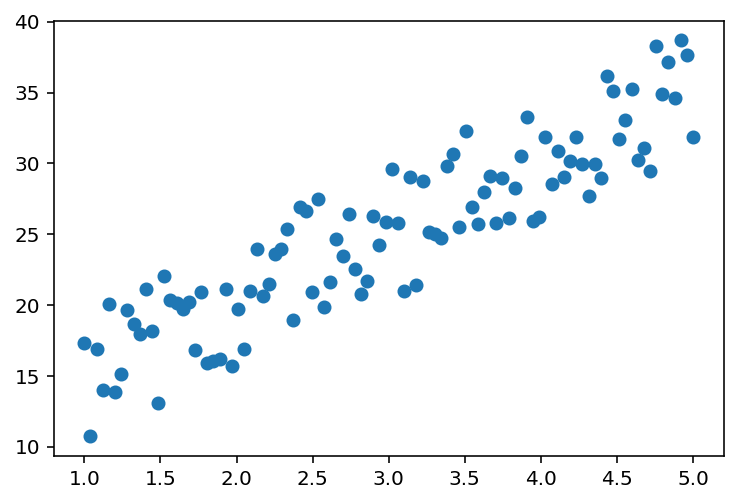

In [3]:
x = np.linspace(1,5,100)
y = np.array([5*(xx+2*np.random.random()- 1)+10 for xx in x])
plt.plot(x,y, 'o')

### 2 Minimization of the cost function

This approach essentially delegates the task of finding $\hat\theta$ to a black box optimizer. We hand it a suitable function for the sum of squared residuals. 

In [22]:
def line(x,m,c):
    return(m*x + c)

def sum_of_squared_residuals(input_x, input_y, line, m, c):
    residual_list = []
    for xx,yy in zip(input_x, input_y):
        residual_list.append( (yy - line(xx,m,c))**2 ) 
    ssr = sum(residual_list)
    return(ssr)    

In [23]:
def ssr_function(c):
    return(sum_of_squared_residuals(x, y, line, 5, c))

Optimization terminated successfully.
         Current function value: 888.636771
         Iterations: 20
         Function evaluations: 40


Text(0, 0.5, '$y$')

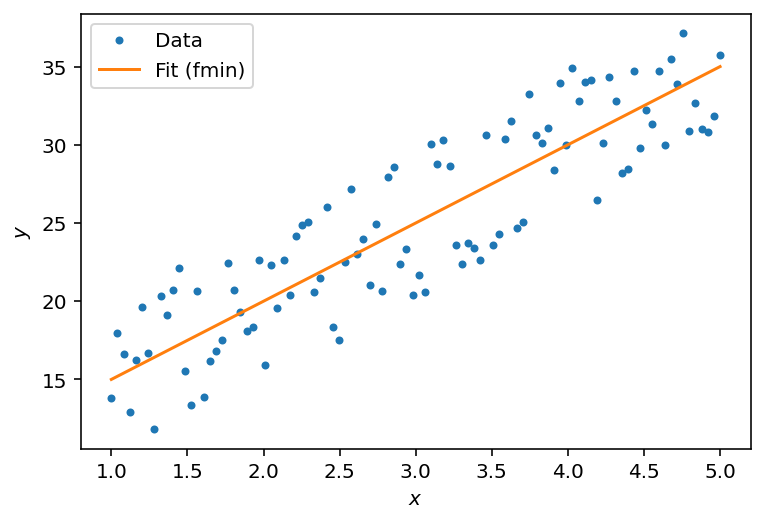

In [25]:
plt.plot(x,y, 'o', label='Data', ms=3)
plt.plot(x, line(x,5, fmin(ssr_function, 5)[0]), '-', label='Fit (fmin)')
plt.legend(loc='best')
plt.xlabel('$x$')
plt.ylabel('$y$')

### 3 Normal equation

If the dataset is small enough to fit into memory, then the optimal parameter vector is 

$$ \hat{\bf \theta} = ({\bf X}^T {\bf X})^{-1} {\bf X}^T y  $$

The term in parentheses can be alternatively calculated with the pseudoinverse, to handle the edge case that ${\bf X}^T {\bf X}$ is not invertible.

The main problem with the normal equation is that the computational complexity of inverting a matrix is huge -- $O(n^3)$, so is impractical for large datasets.

In [20]:
X = np.c_[np.ones_like(x), x]
theta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
print("Param vector from normal equation", theta)
theta = np.linalg.pinv(X).dot(y)
print("Pseudo-inverse form", theta)

Param vector from normal equation [9.88309836 5.17062042]
Pseudo-inverse form [9.88309836 5.17062042]


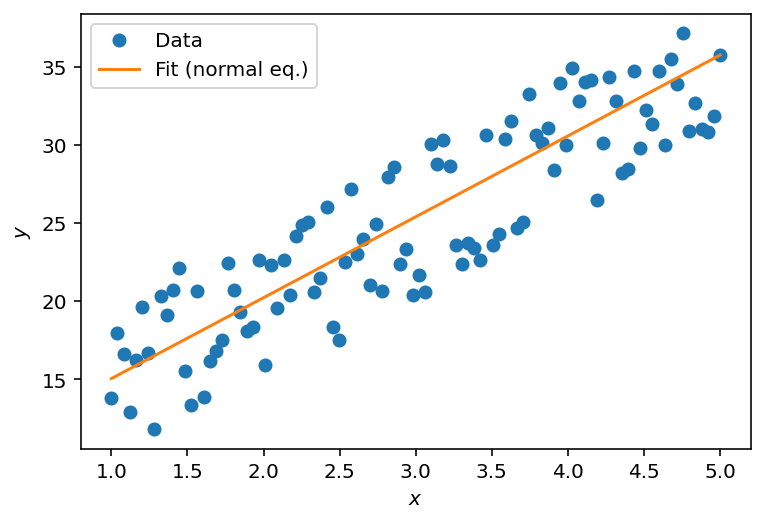

In [21]:
x = np.linspace(1,5,100)
y = np.array([5*(xx+2*np.random.random()- 1)+10 for xx in x])
plt.plot(x,y, 'o', label='Data')
plt.plot(x,theta[0] + theta[1]*x, label='Fit (normal eq.)')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend(loc='best')

### 4 Gradient descent

Finally we consider a generic optimization algorithm known as gradient descent. One starts by defining the parameter vector to optimize, $\hat{\bf \theta}$ as a random array, and then attempt to decrease the cost function until the algorithm converges to some minimum.

Note that we are simultaneously solving for optimal values of both $m$ and $c$, so we must take partial derivatives of the cost function. To keep things clear, let us first write the cost function in terms of the familiar linear equation $y=mx+c$,

$$ S = \frac{1}{N}\sum_i^n (y_i - m\bar x - c)^2 $$

where $N$ is the number of points in the dataset. Note - the derivatives are now partial derivatives, meaning that by extremizing, say $c$, the other variable $m$ is left constant. Now, proceeding, we have

$$ \frac{\partial S}{\partial c} = -\frac{2}{N}\sum_i^n  (y_i - m\bar x - c) $$

$$ \frac{\partial S}{\partial m} = -\frac{2}{N}\bar x \sum_i^n  (y_i - m\bar x - c) $$

We can now update our guesses of $m$ and $c$ iteratively as follows.

100%|██████████| 2000/2000 [00:01<00:00, 1774.66it/s]


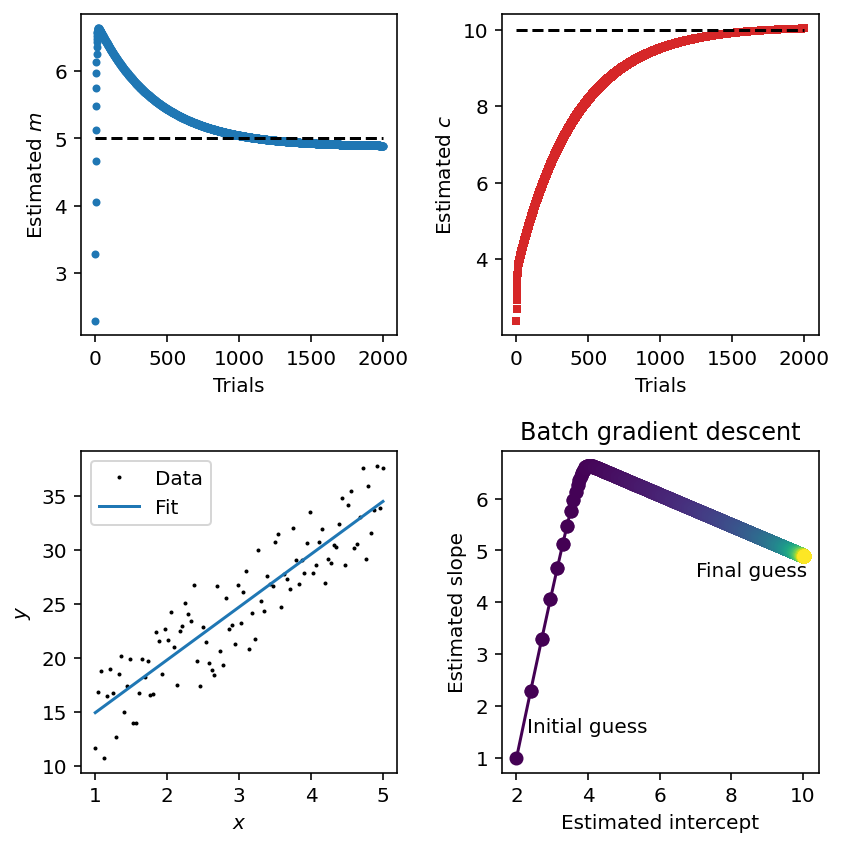

In [29]:
x = np.linspace(1,5,100)
y = np.array([5*(xx+2*np.random.random()- 1)+10 for xx in x])

learning_rate=0.01
mm = 1                           # one slope for each feature
cc = 2                           # one intercept only
fig, ((ax1,ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(6,6))

int_list = []
slope_list = []
int_list.append(cc)
slope_list.append(mm)

for k in tqdm(range(2000)):        
    dSdc = 0
    dSdm = 0

    for i in range(len(x)):
        dSdm += -2*x[i]*(y[i] - mm*x[i] - cc)/len(x)
        dSdc += -2*(y[i] - mm*x[i] - cc)/len(x)

    mm -= dSdm*learning_rate
    cc -= dSdc*learning_rate
    int_list.append(cc)
    slope_list.append(mm)
    ax1.plot(k,mm, 'o', c='C0', ms=3)
    ax2.plot(k,cc, 's', c='C3', ms=3)
    
ax1.set_xlabel('Trials')
ax2.set_xlabel('Trials')
ax1.set_ylabel('Estimated $m$')
ax2.set_ylabel('Estimated $c$')

ax3.plot(x,y, 'ko', ms=1, label='Data')
ax3.plot(x,mm*x+cc, '-', c='C0', label='Fit')
ax3.legend(loc='best')
ax3.set_xlabel('$x$')
ax3.set_ylabel('$y$')

colors = plt.cm.viridis(np.linspace(0,1,len(int_list[0:])))
for i in range(len(int_list[0:])-1):
    ax4.plot([int_list[0:][i], int_list[0:][i+1]], [slope_list[0:][i], slope_list[0:][i+1]], 'o-', c=colors[i])
ax4.set_xlabel('Estimated intercept')
ax4.set_ylabel('Estimated slope')
ax4.text(2.3, 1.5, 'Initial guess')
ax4.text(7, 4.5, 'Final guess')
ax4.set_title('Batch gradient descent')

ax1.plot([0,2000], [5,5], 'k--')
ax2.plot([0,2000], [10,10], 'k--')
plt.tight_layout()

#### 4a Vectorised gradient descent

A more elegant way to do the above is to vectorise the equation

$$ S\equiv {\rm MSE} ({\bf X}, {\bf h}_\theta)= {1\over m}\sum_{i=1}^m \left( {\bf \theta}^T x^{(i)}-y^{(i)} \right)^2 $$

and now evaluate its partial derivatives

$$ {\partial S\over\partial \theta_j} = {2\over m} \sum_{i=1}^m (\theta^T x^{(i)} - y^{(i)})x^{(i)} $$

with 

$$ \nabla_\theta S = \begin{pmatrix} {\partial S/\partial\theta_0} \\ \dots \\ {\partial S/\partial\theta_n} \end{pmatrix} $$

Then, the gradient descent is updated as

$$ \theta^{t+1} = \theta^t - \eta \nabla_\theta S $$

The vectorised calculation is very short indeed -- just four lines to perform everything and store trained model parameters $(c,m)$.

In [102]:
x = np.linspace(1,5,100)
y = np.array([5*(xx+2*np.random.random()- 1)+10 for xx in x])

eta = 0.1   # learning rate
n = 1000    # number of iterations
m = len(x)  # number of entries in dataset
theta = [0,0] # Initial guess of the parameter vector, can be set to be random as well
xb = np.c_[np.ones_like(x), x] # add a bias column

m_list = []
c_list = []

for k in range(n):
    nabla_S = 1/m*xb.T.dot( xb.dot(theta) - y )
    theta -= eta * nabla_S
    c_list.append(theta[0])
    m_list.append(theta[1])

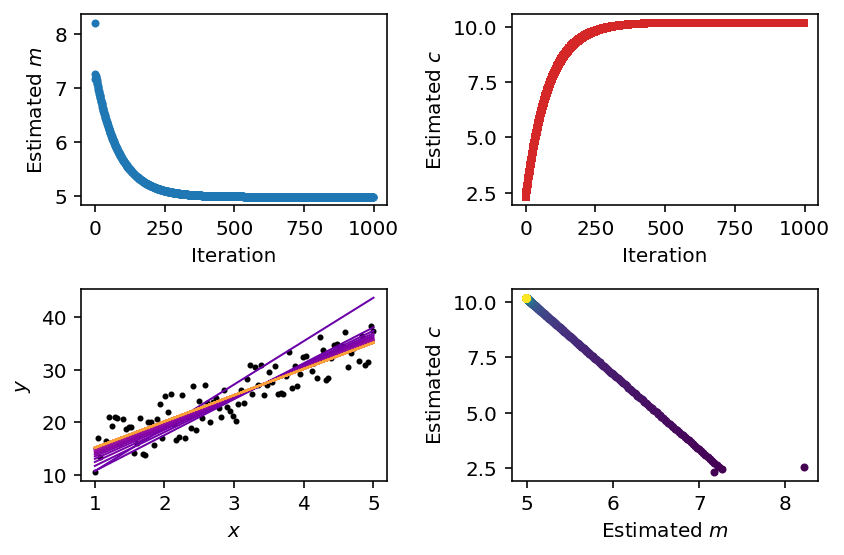

In [103]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(6,4))
ax1.plot(m_list, 'o', ms=3)
ax2.plot(c_list, 's', c='C3', ms=3)
ax3.plot(x, y, 'o', label='Data', ms=2, c='k')
ccycle = iter(plt.cm.plasma(np.linspace(0.2,0.8,len(m_list))))
count = 0
for m,c in zip(m_list, c_list):
    cc = next(ccycle)
    if count % 20 == 0:
        ax3.plot(x, m*x + c, c=cc, lw=1)
    count += 1
ax3.set_xlabel('$x$')
ax3.set_ylabel('$y$')
#ax3.legend(loc='best')

colors = iter(plt.cm.viridis(np.linspace(0,1,len(m_list))))
for m,c in zip(m_list, c_list):
    cc = next(colors)
    plt.plot(m,c, 'o', c=cc, ms=3)

ax1.set_ylabel('Estimated $m$')
ax2.set_ylabel('Estimated $c$')
ax1.set_xlabel('Iteration')
ax2.set_xlabel('Iteration')
ax4.set_xlabel('Estimated $m$')
ax4.set_ylabel('Estimated $c$')
plt.tight_layout()

The evolution of the fitted line can be seen in the lower left subplot. The first guess is the isolated purple line, jumping to the second guess that adjusts relatively slowly until the final guess in pink.  

### 4c Minibatch gradient descent

Batch gradient descent considers the entire dataset at once. The computation can be sped up significantly if, at every timestep, we fit only a random subset of the data. 

In [106]:
np.random.choice(np.arange(len(x)), int(0.1*len(x)), replace=False)

array([51, 95, 10, 25, 29, 61,  9, 84, 54, 38])

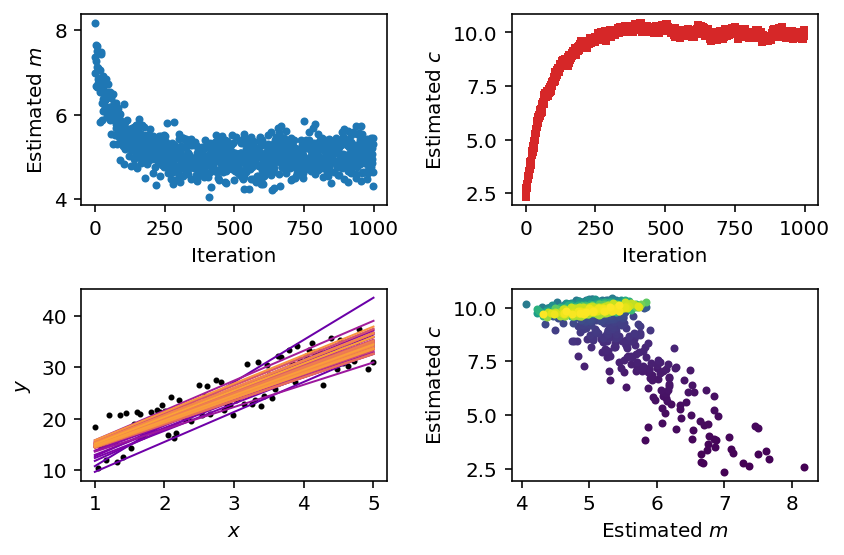

In [108]:
x = np.linspace(1,5,100)
y = np.array([5*(xx+2*np.random.random()- 1)+10 for xx in x])

eta = 0.1   # learning rate
n = 1000    # number of iterations
m = len(x)  # number of entries in dataset
theta = [0,0] # Initial guess of the parameter vector, can be set to be random as well
xb = np.c_[np.ones_like(x), x] # add a bias column

m_list = []
c_list = []

for k in range(n):

    # Select some subset of the data - here 10%
    random_idx = np.random.choice(np.arange(len(x)), int(0.1*len(x)), replace=False)

    m = len(random_idx)
    nabla_S = 1/m*xb[random_idx].T.dot( xb[random_idx].dot(theta) - y[random_idx] )
    theta -= eta * nabla_S
    c_list.append(theta[0])
    m_list.append(theta[1])

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(6,4))
ax1.plot(m_list, 'o', ms=3)
ax2.plot(c_list, 's', c='C3', ms=3)
ax3.plot(x, y, 'o', label='Data', ms=2, c='k')
ccycle = iter(plt.cm.plasma(np.linspace(0.2,0.8,len(m_list))))
count = 0
for m,c in zip(m_list, c_list):
    cc = next(ccycle)
    if count % 20 == 0:
        ax3.plot(x, m*x + c, c=cc, lw=1)
    count += 1
ax3.set_xlabel('$x$')
ax3.set_ylabel('$y$')
#ax3.legend(loc='best')

colors = iter(plt.cm.viridis(np.linspace(0,1,len(m_list))))
for m,c in zip(m_list, c_list):
    cc = next(colors)
    plt.plot(m,c, 'o', c=cc, ms=3)

ax1.set_ylabel('Estimated $m$')
ax2.set_ylabel('Estimated $c$')
ax1.set_xlabel('Iteration')
ax2.set_xlabel('Iteration')
ax4.set_xlabel('Estimated $m$')
ax4.set_ylabel('Estimated $c$')
plt.tight_layout()    

Things look a little rougher here as compared to the clean convergence of batch gradient descent. Note that, due to stocasticity, the minibatch gradient descent will fluctuate about the optimal $\hat \theta$, as one can see from the relative fatness of the estimated $m$ (upper left) close to iteration 1000, or the yellow band in the subplot lower left (the points here are coloured from early in purple to late in yellow). One can get best of both worlds by a good choice of learning policy or learning schedule. 

### 5 Polynomial regression

Polynomial regression is a straightforward extension of linear regression. Now, the cost function is

$$ {\rm MSE} ({\bf X}, {\bf h}_\theta)= {1\over m}\sum_{i=1}^m \left( {\bf \theta}^T X^{(i)}-y^{(i)} \right)^2 $$

where

$$ X^{(i)} = \begin{pmatrix} 1 \\ {x^{(i)}} \\ \dots \\ {x^{(i)}}^n \end{pmatrix} $$


In [275]:

def polynomial_gd(x, y, degree=3, n=2000, eta=0.1):
    '''
    Performs gradient descent of a specified polynomial degree, then returns
    the parameter vector theta. 

    Parameters
    ----------
    x, list/np.array

    y, list/np.array

    degree, int
        Polynomial degree

    n, int
        Number of iterations

    eta, float
        Learning rate
    '''

    m = len(x)  # number of entries in dataset

    # Populate the X matrix
    X = np.zeros((len(x), degree+1))
    theta = np.zeros(X.shape[1])
    for i in range(degree):
        X[:,i] = x**i

    for k in range(n): # Gradient descent
        nabla_S = 1/m*X.T.dot(X.dot(theta) - y)
        theta -= eta * nabla_S
    return(theta)

# Generate the fitting polynomial
def generate_polynomial(x, theta):
    output = np.zeros_like(x)
    for i in range(len(theta)):
        output += theta[i]*x**i
    return output

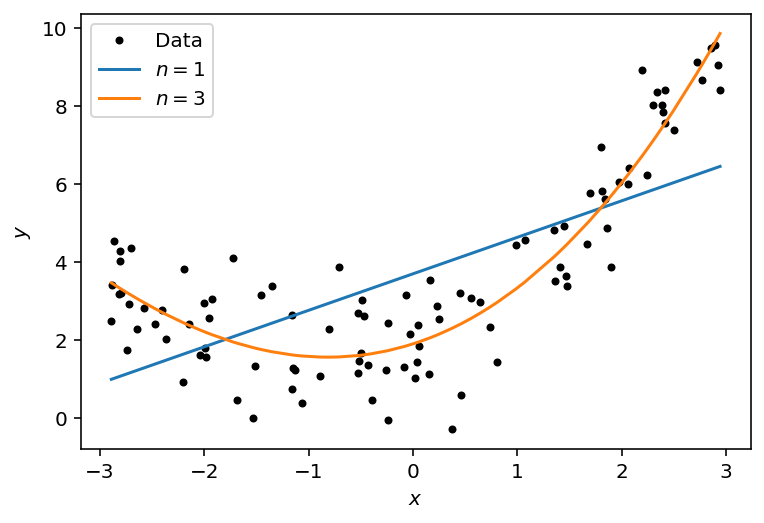

In [293]:
x = 6*np.random.rand(100,) - 3
x = np.array(sorted(x))
y = 0.5*x**2 + x + 2 +np.random.randn(100,)

theta_1 = polynomial_gd(x,y, degree=2, n=1000, eta=0.01)
theta_2 = polynomial_gd(x,y, degree=4, n=1000, eta=0.01)

plt.plot(x,y, 'o', ms=3, c='k', label='Data')
plt.plot(x,generate_polynomial(x,theta_1), label='$n=1$')
plt.plot(x,generate_polynomial(x,theta_2), label='$n=3$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend(loc='best')